# Results Synthesis 
## Inputs (Files)
From `outputs/tables/`:
- `tx_length_by_fhsz_class.csv`
- `tx_overlap_any_fire_total.csv`
- `tx_overlap_any_fire_by_line.csv`
- `tx_joint_exposure_summary.csv`
- `tx_joint_exposure_top25_lines.csv`

## Outputs (Files)
To `outputs/tables/`:
- `report_exec_summary.csv`
- `report_overlap_by_hazard_class.csv`
- `report_top25_joint_exposure_lines.csv`

To `outputs/figures/`:
- `fig_fhsz_overlap_by_class.png`
- `fig_exposure_funnel.png`
- `fig_joint_exposure_pareto.png`

### Imports

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Define Paths

In [2]:
CWD = Path.cwd()
ROOT = CWD.parent if CWD.name.lower() == "notebooks" else CWD

TABLES = ROOT / "outputs" / "tables"
FIGS = ROOT / "outputs" / "figures"
FIGS.mkdir(parents=True, exist_ok=True)

print("TABLES:", TABLES)
print("FIGS:", FIGS)

TABLES: C:\dev\wildfire\Wildfire-Exposure-of-California-Transmission-Infrastructure\outputs\tables
FIGS: C:\dev\wildfire\Wildfire-Exposure-of-California-Transmission-Infrastructure\outputs\figures


## Prechecks

In [3]:
required = [
    "tx_length_by_fhsz_class.csv",
    "tx_overlap_any_fire_total.csv",
    "tx_overlap_any_fire_by_line.csv",
    "tx_joint_exposure_summary.csv",
    "tx_joint_exposure_top25_lines.csv",
]

missing = [f for f in required if not (TABLES / f).exists()]
if missing:
    raise FileNotFoundError(f"Missing required inputs in outputs/tables/: {missing}")

df_fhsz = pd.read_csv(TABLES / "tx_length_by_fhsz_class.csv")
df_fire_total = pd.read_csv(TABLES / "tx_overlap_any_fire_total.csv")
df_fire_by_line = pd.read_csv(TABLES / "tx_overlap_any_fire_by_line.csv")
df_joint_summary = pd.read_csv(TABLES / "tx_joint_exposure_summary.csv")
df_joint_top25 = pd.read_csv(TABLES / "tx_joint_exposure_top25_lines.csv")

df_fhsz.head()

,hazard_class,overlap_km
0,NonWildland,13908.787465
1,Very High,7126.069250
2,High,6876.888507
3,Moderate,6286.233349


## Clean & Standardize

In [4]:
df_fhsz = df_fhsz.copy()
df_fhsz["overlap_km"] = pd.to_numeric(df_fhsz["overlap_km"], errors="coerce")

# Ensure consistent hazard class ordering for charts/tables
hazard_order = ["NonWildland", "Moderate", "High", "Very High"]
df_fhsz["hazard_class"] = pd.Categorical(df_fhsz["hazard_class"], categories=hazard_order, ordered=True)
df_fhsz = df_fhsz.sort_values("hazard_class")

total_tx_km = float(df_fhsz["overlap_km"].sum())

total_fire_km = float(df_fire_total.loc[0, "total_overlap_km"])
n_lines_with_fire = int(df_fire_total.loc[0, "n_lines_with_overlap"])

total_joint_km = float(df_joint_summary.loc[0, "total_joint_km"])
n_lines_with_joint = int(df_joint_summary.loc[0, "n_lines_with_joint_exposure"])

very_high_km = float(df_fhsz.loc[df_fhsz["hazard_class"] == "Very High", "overlap_km"].iloc[0])

(total_tx_km, very_high_km, total_fire_km, total_joint_km)

(34197.97857113975, 7126.069249952414, 156.93399369133007, 57.04165069488604)

## Build Executive Summary Table

In [5]:
exec_summary = pd.DataFrame(
    [
        {"metric": "Total transmission length analyzed (km)", "value": total_tx_km},
        {"metric": "Transmission length in Very High FHSZ (km)", "value": very_high_km},
        {"metric": "Transmission length intersecting historical fire perimeters (km)", "value": total_fire_km},
        {"metric": "Joint exposure length (Very High FHSZ ∩ historical fire) (km)", "value": total_joint_km},
        {"metric": "Lines with any historical fire overlap (count)", "value": n_lines_with_fire},
        {"metric": "Lines with joint exposure (count)", "value": n_lines_with_joint},
        {"metric": "Very High share of total analyzed length (%)", "value": 100.0 * very_high_km / total_tx_km},
        {"metric": "Joint share of Very High length (%)", "value": 100.0 * total_joint_km / very_high_km if very_high_km else np.nan},
        {"metric": "Joint share of total analyzed length (%)", "value": 100.0 * total_joint_km / total_tx_km},
    ]
)

exec_summary.to_csv(TABLES / "report_exec_summary.csv", index=False)
exec_summary

,metric,value
0,Total transmission length analyzed (km),34197.978571
1,Transmission length in Very High FHSZ (km),7126.069250
2,Transmission length intersecting historical fi...,156.933994
3,Joint exposure length (Very High FHSZ ∩ histor...,57.041651
4,Lines with any historical fire overlap (count),133.000000
5,Lines with joint exposure (count),78.000000
6,Very High share of total analyzed length (%),20.837691
7,Joint share of Very High length (%),0.800464
8,Joint share of total analyzed length (%),0.166798


### Save Hazard Table

In [6]:
report_hazard = df_fhsz[["hazard_class", "overlap_km"]].copy()
report_hazard["share_of_total_%"] = 100.0 * report_hazard["overlap_km"] / total_tx_km
report_hazard.to_csv(TABLES / "report_overlap_by_hazard_class.csv", index=False)
report_hazard

,hazard_class,overlap_km,share_of_total_%
0,NonWildland,13908.787465,40.671373
3,Moderate,6286.233349,18.381886
2,High,6876.888507,20.109050
1,Very High,7126.069250,20.837691


### Save Top 25 Joint Exposure Lines Table

In [7]:
df_joint_top25 = df_joint_top25.copy()
df_joint_top25["joint_km"] = pd.to_numeric(df_joint_top25["joint_km"], errors="coerce")

df_joint_top25.to_csv(TABLES / "report_top25_joint_exposure_lines.csv", index=False)
df_joint_top25.head(10)

,line_id,owner,voltage_kv,joint_km
0,1779,SAN DIEGO GAS & ELECTRIC,500.0,2.878978
1,2052,SOUTHERN CALIFORNIA EDISON,115.0,2.369641
2,2053,SOUTHERN CALIFORNIA EDISON,115.0,2.357310
3,795,PACIFIC GAS & ELECTRIC COMPANY,115.0,2.345002
4,626,PACIFIC GAS & ELECTRIC COMPANY,115.0,2.336808
5,772,PACIFIC GAS & ELECTRIC COMPANY,500.0,2.301639
6,1789,PACIFIC GAS & ELECTRIC COMPANY,500.0,2.125935
7,2064,SOUTERN CALIFORNIA EDISON,115.0,2.104791
8,1276,PACIFIC GAS & ELECTRIC COMPANY,230.0,1.728080
9,165,PACIFIC GAS & ELECTRIC COMPANY,115.0,1.646570


## Figure: Overlap by Hazard Class

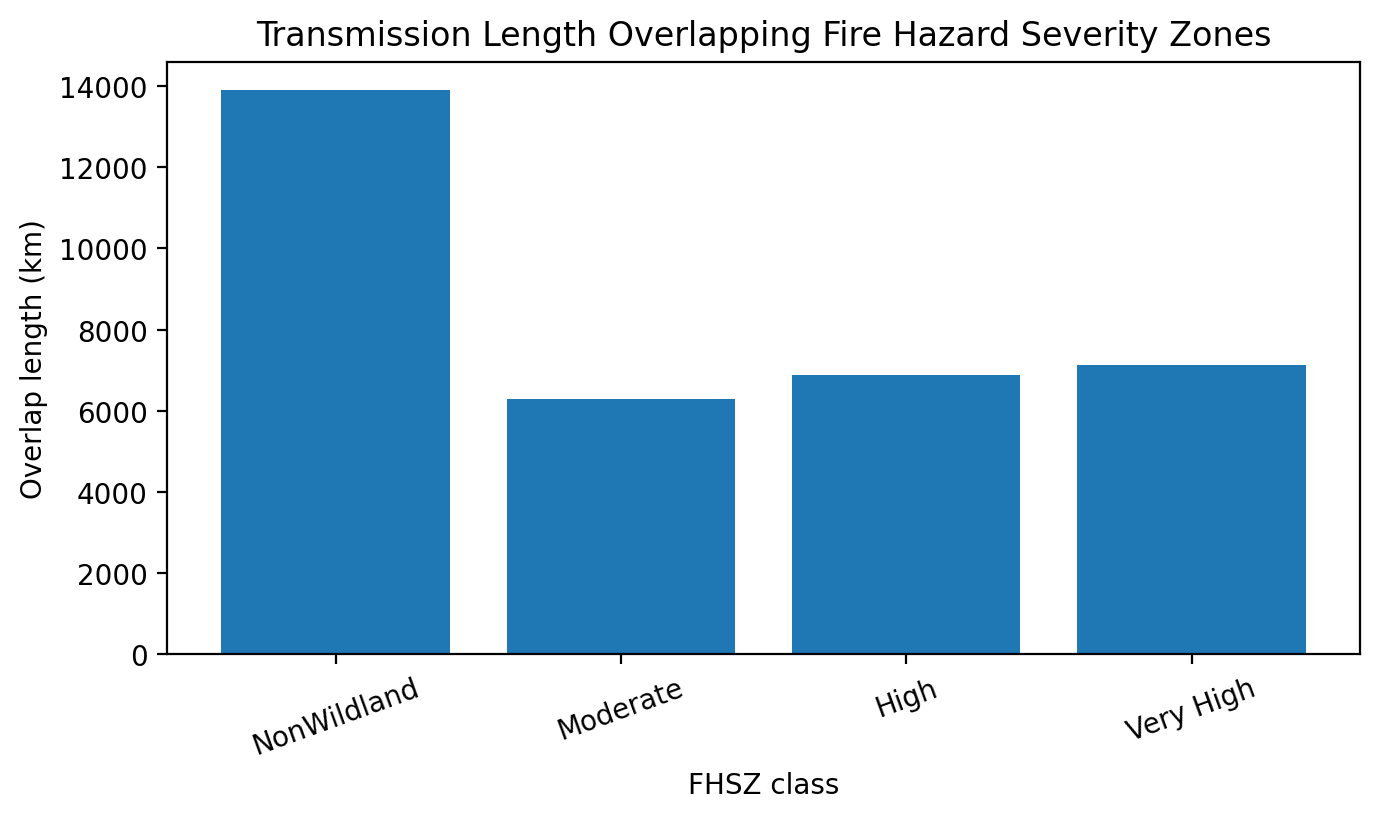

Saved: C:\dev\wildfire\Wildfire-Exposure-of-California-Transmission-Infrastructure\outputs\figures\fig_fhsz_overlap_by_class.png


In [8]:
fig = plt.figure(figsize=(7, 4.2), dpi=200)
ax = plt.gca()

ax.bar(df_fhsz["hazard_class"].astype(str), df_fhsz["overlap_km"])
ax.set_title("Transmission Length Overlapping Fire Hazard Severity Zones")
ax.set_ylabel("Overlap length (km)")
ax.set_xlabel("FHSZ class")
ax.tick_params(axis="x", rotation=20)

plt.tight_layout()
outpath = FIGS / "fig_fhsz_overlap_by_class.png"
plt.savefig(outpath, dpi=300)
plt.show()

print("Saved:", outpath)

## Figure: Exposure Funnel

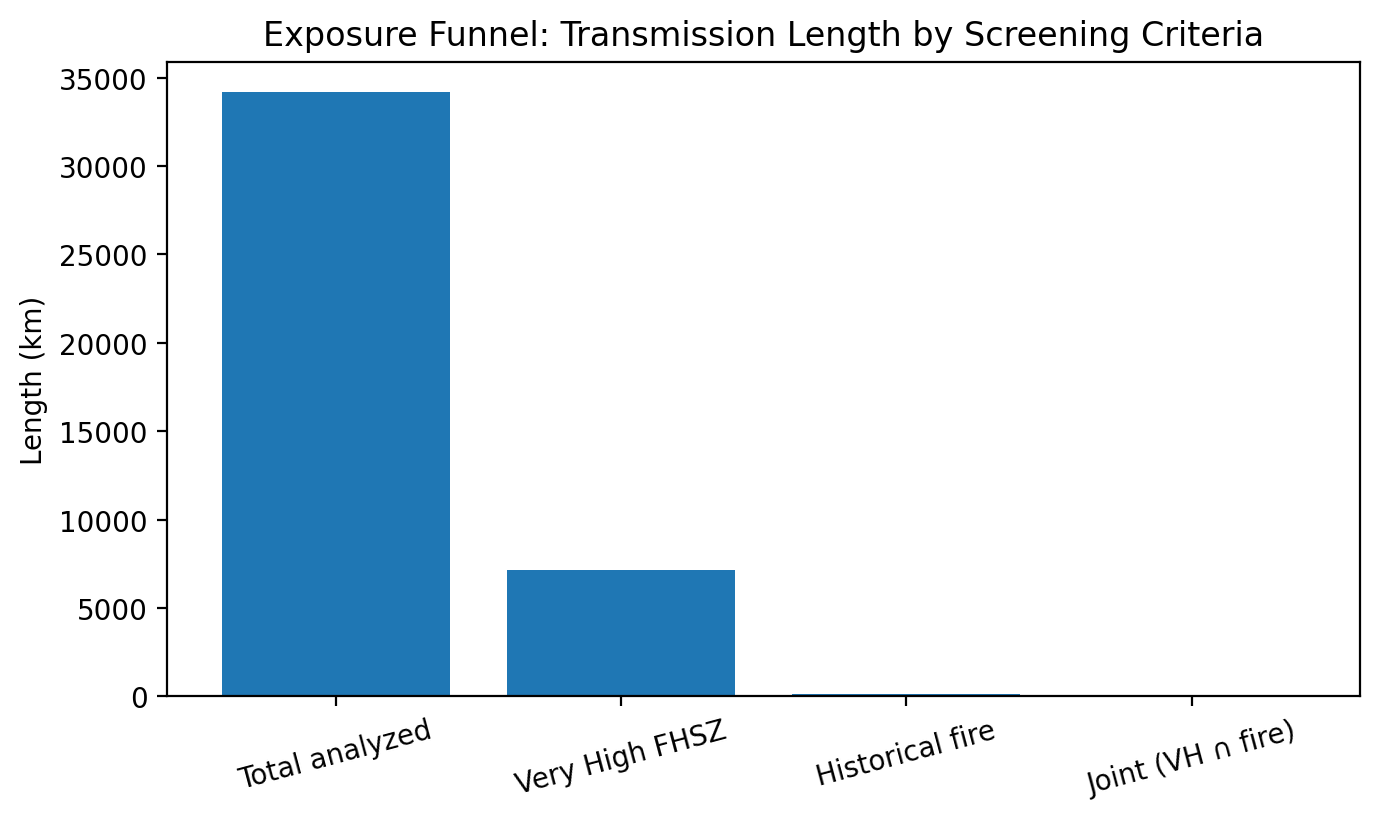

Saved: C:\dev\wildfire\Wildfire-Exposure-of-California-Transmission-Infrastructure\outputs\figures\fig_exposure_funnel.png


In [9]:
stages = ["Total analyzed", "Very High FHSZ", "Historical fire", "Joint (VH ∩ fire)"]
values = [total_tx_km, very_high_km, total_fire_km, total_joint_km]

fig = plt.figure(figsize=(7, 4.2), dpi=200)
ax = plt.gca()

ax.bar(stages, values)
ax.set_title("Exposure Funnel: Transmission Length by Screening Criteria")
ax.set_ylabel("Length (km)")
ax.tick_params(axis="x", rotation=15)

plt.tight_layout()
outpath = FIGS / "fig_exposure_funnel.png"
plt.savefig(outpath, dpi=300)
plt.show()

print("Saved:", outpath)

## Figure: Concentration of Joint Exposure Across Lines

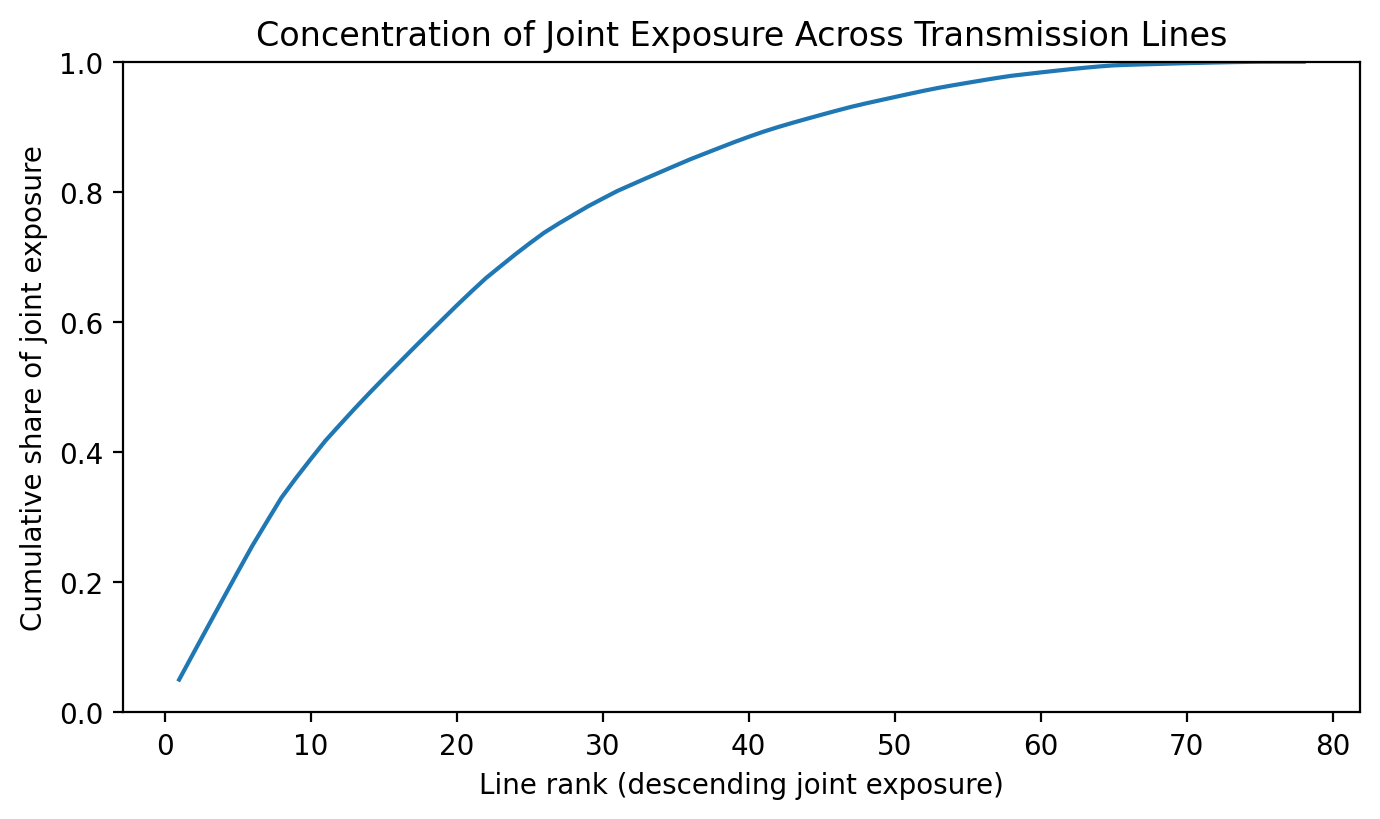

Saved: C:\dev\wildfire\Wildfire-Exposure-of-California-Transmission-Infrastructure\outputs\figures\fig_joint_exposure_pareto.png


In [10]:
joint_by_line = pd.read_csv(TABLES / "tx_joint_exposure_by_line.csv")
joint_by_line["joint_km"] = pd.to_numeric(joint_by_line["joint_km"], errors="coerce")
joint_by_line = joint_by_line.dropna().sort_values("joint_km", ascending=False)

joint_by_line["cum_km"] = joint_by_line["joint_km"].cumsum()
total = joint_by_line["joint_km"].sum()
joint_by_line["cum_share"] = joint_by_line["cum_km"] / total if total else np.nan
joint_by_line["rank"] = np.arange(1, len(joint_by_line) + 1)

fig = plt.figure(figsize=(7, 4.2), dpi=200)
ax = plt.gca()

ax.plot(joint_by_line["rank"], joint_by_line["cum_share"])
ax.set_title("Concentration of Joint Exposure Across Transmission Lines")
ax.set_xlabel("Line rank (descending joint exposure)")
ax.set_ylabel("Cumulative share of joint exposure")
ax.set_ylim(0, 1.0)

plt.tight_layout()
outpath = FIGS / "fig_joint_exposure_pareto.png"
plt.savefig(outpath, dpi=300)
plt.show()

print("Saved:", outpath)

## Final Outputs Checklist

In [11]:
outputs = [
    TABLES / "report_exec_summary.csv",
    TABLES / "report_overlap_by_hazard_class.csv",
    TABLES / "report_top25_joint_exposure_lines.csv",
    FIGS / "fig_fhsz_overlap_by_class.png",
    FIGS / "fig_exposure_funnel.png",
    FIGS / "fig_joint_exposure_pareto.png",
]

for p in outputs:
    print(("OK  " if p.exists() else "MISS"), p)

OK   C:\dev\wildfire\Wildfire-Exposure-of-California-Transmission-Infrastructure\outputs\tables\report_exec_summary.csv
OK   C:\dev\wildfire\Wildfire-Exposure-of-California-Transmission-Infrastructure\outputs\tables\report_overlap_by_hazard_class.csv
OK   C:\dev\wildfire\Wildfire-Exposure-of-California-Transmission-Infrastructure\outputs\tables\report_top25_joint_exposure_lines.csv
OK   C:\dev\wildfire\Wildfire-Exposure-of-California-Transmission-Infrastructure\outputs\figures\fig_fhsz_overlap_by_class.png
OK   C:\dev\wildfire\Wildfire-Exposure-of-California-Transmission-Infrastructure\outputs\figures\fig_exposure_funnel.png
OK   C:\dev\wildfire\Wildfire-Exposure-of-California-Transmission-Infrastructure\outputs\figures\fig_joint_exposure_pareto.png
